# GLOBAL SUPERSTORE DATASET SALES ANALYSIS
By Raju Vaneshwar Nareshwar

## 1. Task 1

### Load first 10 records

In [81]:
# pip install packages
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install adjustText

# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import socket
import requests
import geopandas as gpd

from matplotlib import ticker as mtick
from tabulate import tabulate
from adjustText import adjust_text

# Letting pandas to show max columns
pd.set_option('display.max_columns', None)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [82]:
# Reading CSV file and assigning into a dataframe ss_data
global_super_store_df_org = pd.read_csv('sample-superstore-2023-T3.csv')

# Copy the dataframe before processing
global_super_store_df = global_super_store_df_org.copy();

# Set the head to 10 to retrieve the first 10 records
first_10_rows = global_super_store_df.head(n=10)
first_10_rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7773,CA-2016-108196,25/11/2016,12/02/2016,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,Ohio,43130,Est,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.978
1,684,US-2017-168116,11/04/2017,11/04/2017,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,North Carolina,"""27217""",South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
2,9775,CA-2014-169019,26/07/2014,30/07/2014,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,78207,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
3,3012,CA-2017-134845,17/04/2017,24/04/2017,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,Colorado,80027,West,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.98
4,4992,US-2017-122714,12/07/2017,13/12/2017,Standard Class,HG-14965,Henry Goldwyn,Corporate,United States,Chicago,Illinois,60653,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
5,3152,CA-2015-147830,15/12/2015,18/12/2015,First Class,NF-18385,Natalie Fritzler,Consumer,United States,Newark,Ohio,43055,East,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,Two,0.7,"""-2639.9912"""
6,5311,CA-2017-131254,19/11/2017,21/11/2017,First Class,NC-18415,Nathan Cano,Consumer,United States,Houston,Texas,77095,Central,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.782
7,9640,CA-2015-116638,28/01/2015,NaN,Second Class,JH-15985,Joseph Holt,Consumer,United States,Concord,North Carolina,28027,South,FUR-TA-10000198,Frnture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,Thirteen,0.4,NaN
8,1200,CA-2016-130946,04/08/2016,04/12/2016,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,Texas,77041,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9,2698,CA-2014-145317,18/03/2014,23/03/2014,Standard Class,SM-20320,Sean Miller,Home Office,NaN,Jacksonville,Florida,32216,Southh,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784


### Understanding of the dataset

#### Information of descriptive statistics

Using info() and describe() function to get the descriptive statistics

In [83]:
# Get the metadata information about the dataset
# Grouping data types by category
numerical_columns = global_super_store_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = global_super_store_df.select_dtypes(include=['object']).columns
datetime_columns = global_super_store_df.select_dtypes(include=['datetime64']).columns

# Define a table width and print the header row with a dotted line
table_width = 215
print("-" * table_width)

# Print each row of the table with content and a dash line
content_list = [f"We are working with a {global_super_store_df.shape} sized dataset.", 
                    f"Numercial columns: {', '.join(numerical_columns)}",
                    f"Categorical columns: {', '.join(categorical_columns)}",
                    f"Date Time columns: {', '.join(datetime_columns)}"]

for content_row in content_list:
    print("| {:<211} |".format(content_row))
    print("-" * table_width)

# Get descriptive statistics on the dataset
description_table = tabulate(global_super_store_df.describe(), headers='keys', tablefmt='pretty')

# Print the table
print(description_table)

# Print metatype information about the dataset
print(global_super_store_df.info())


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| We are working with a (9994, 21) sized dataset.                                                                                                                                                                     |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| Numercial columns: Row ID, Sales, Discount                                                                                                                                                                          |
----------------------------------------------------------------------------------------------------------------------------------------

The primary key of these records are a system-generated, and denoted as column: *RowID*

The datatypes of the dataset are following:
* int64(1)
* float64(2)
* object(18)

A few records of *Quantity* and *Profit* columns has the datatype of object, but it must be float64, thus needs to be cleansed or transformed.  

*Ship Date* and *Order Date* columns are represented as strings, those needs to be converted as datetime.

Once cleansed, the descriptive statistics can be applied to the numerial columns, and they are Sales, Quantity, Discount and Profit.


#### Histograms based on categorical features

In [84]:
def plot_histogram(data, xlabel, ylabel, title): 
    
    """    
    plot_histogram generates a histogram plot for the given dataset.
    Parameters:
      data: Dataset for the histogram plot (pandas Series or any iterable).
      xlabel: Label for the x-axis.
      ylabel: Label for the y-axis.
      title: Title of the plot.
    Returns: None
    
    """
    
    plt.figure(figsize=(12, 10))

    bars = plt.bar(data.index, data)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    plt.show()

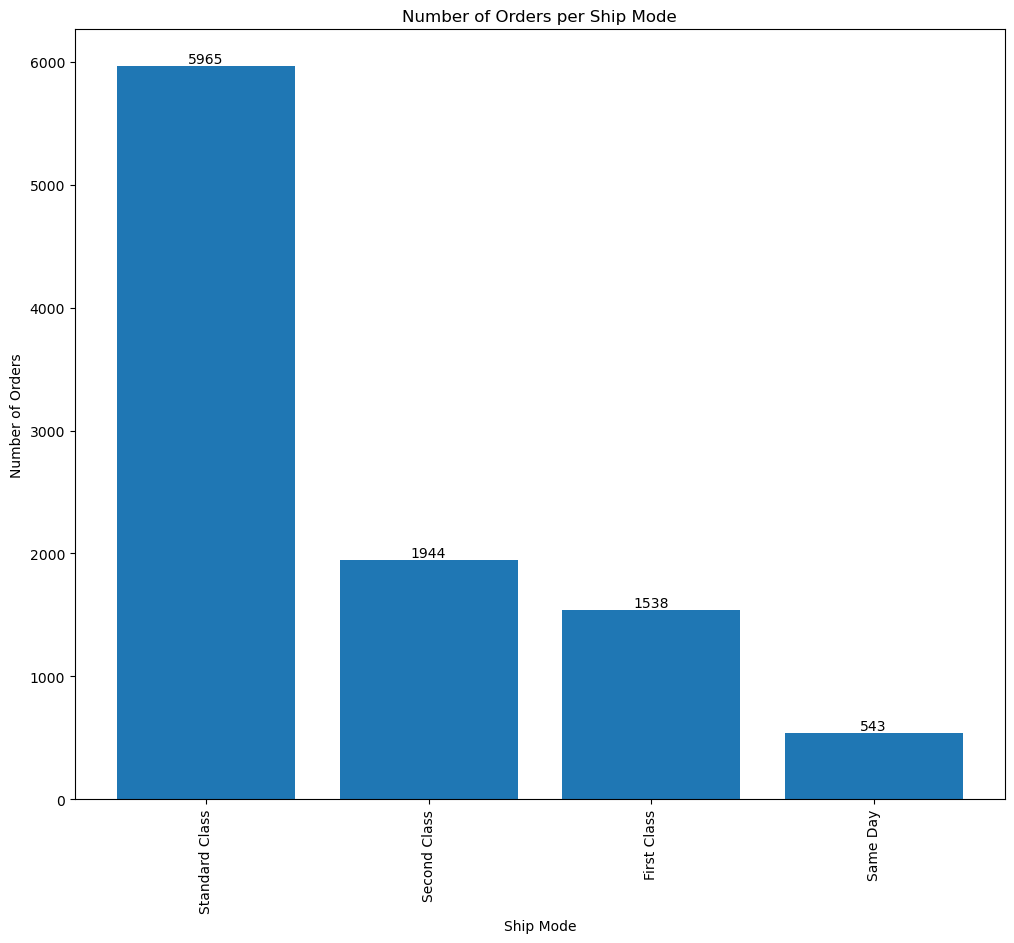

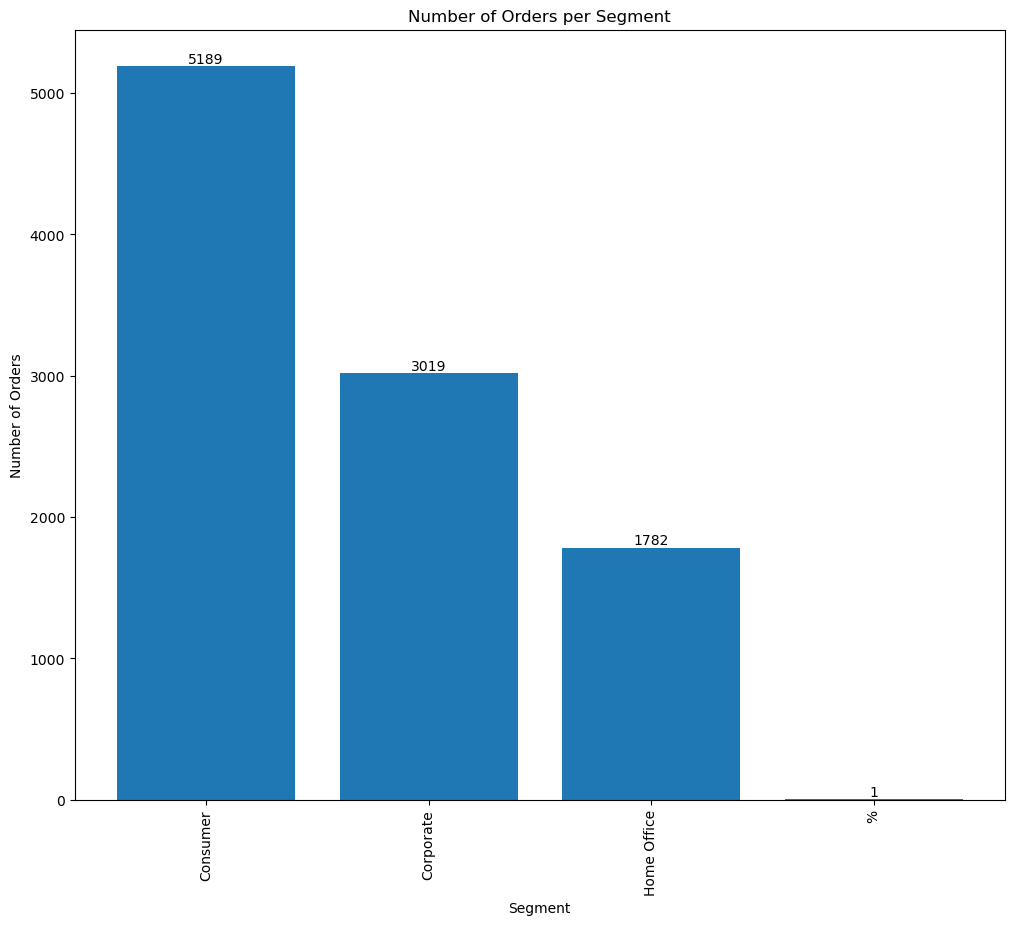

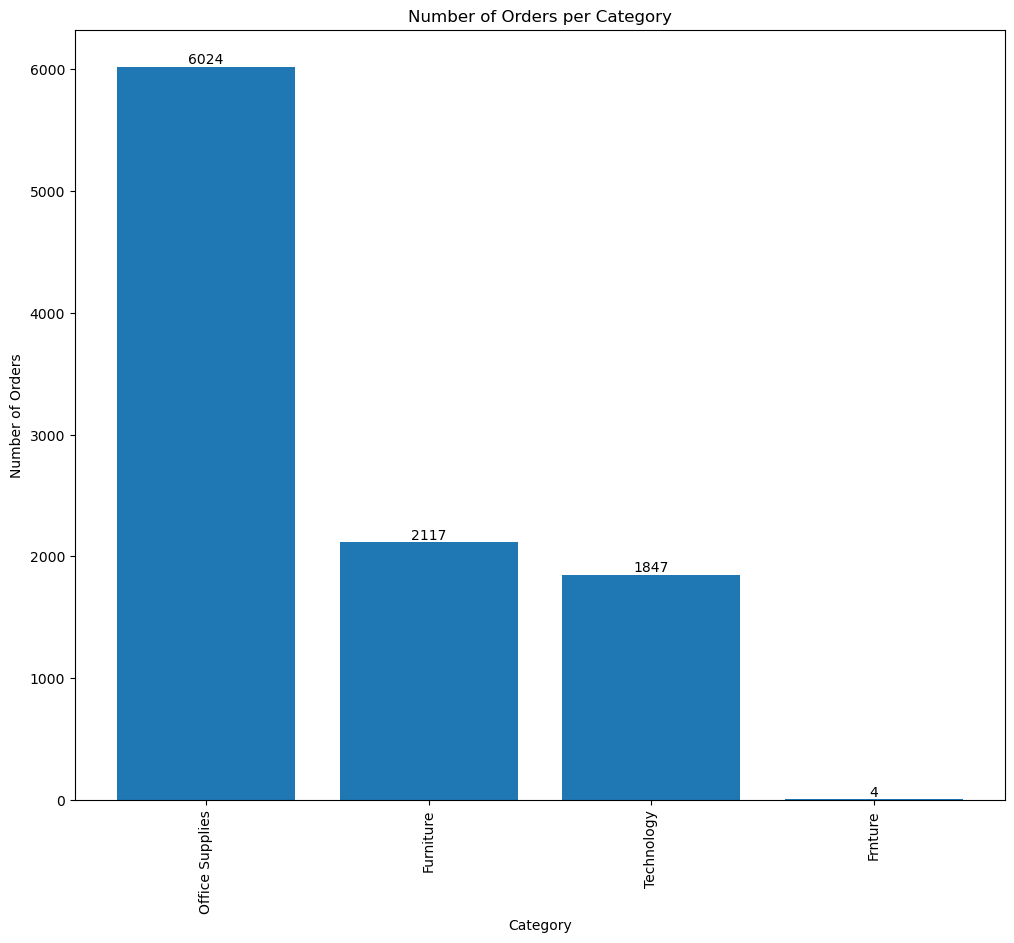

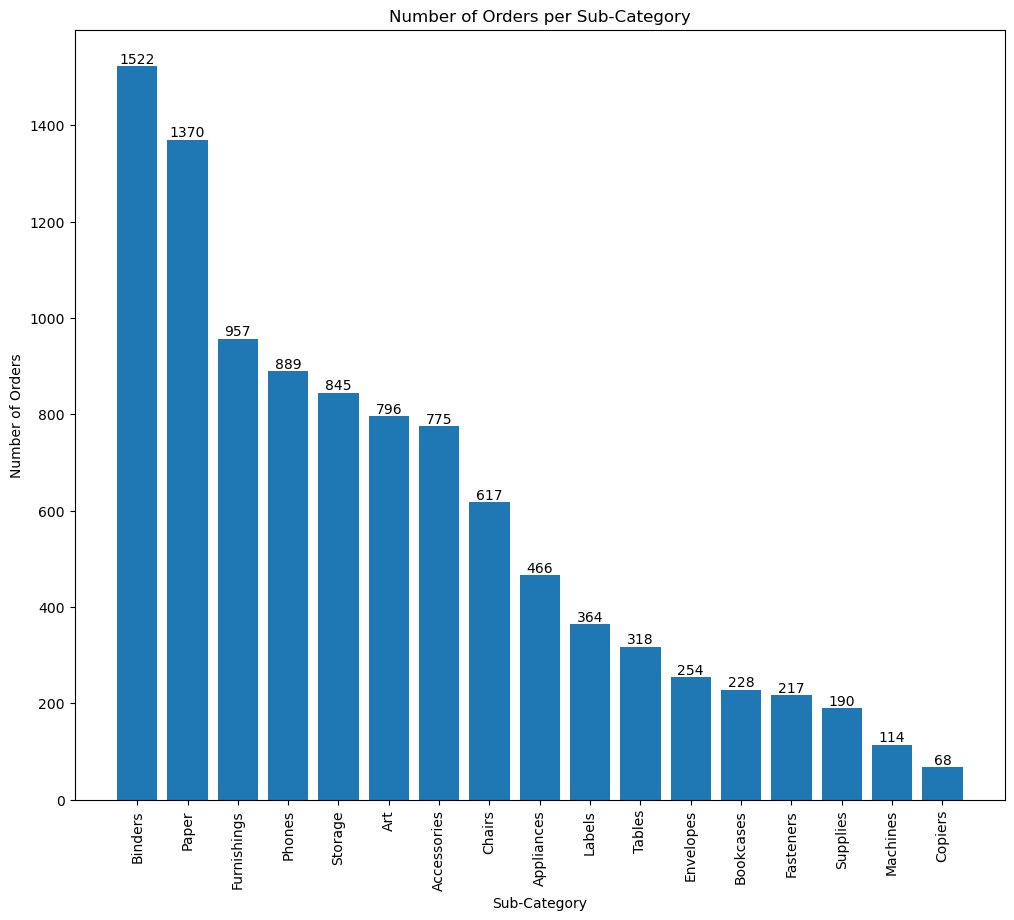

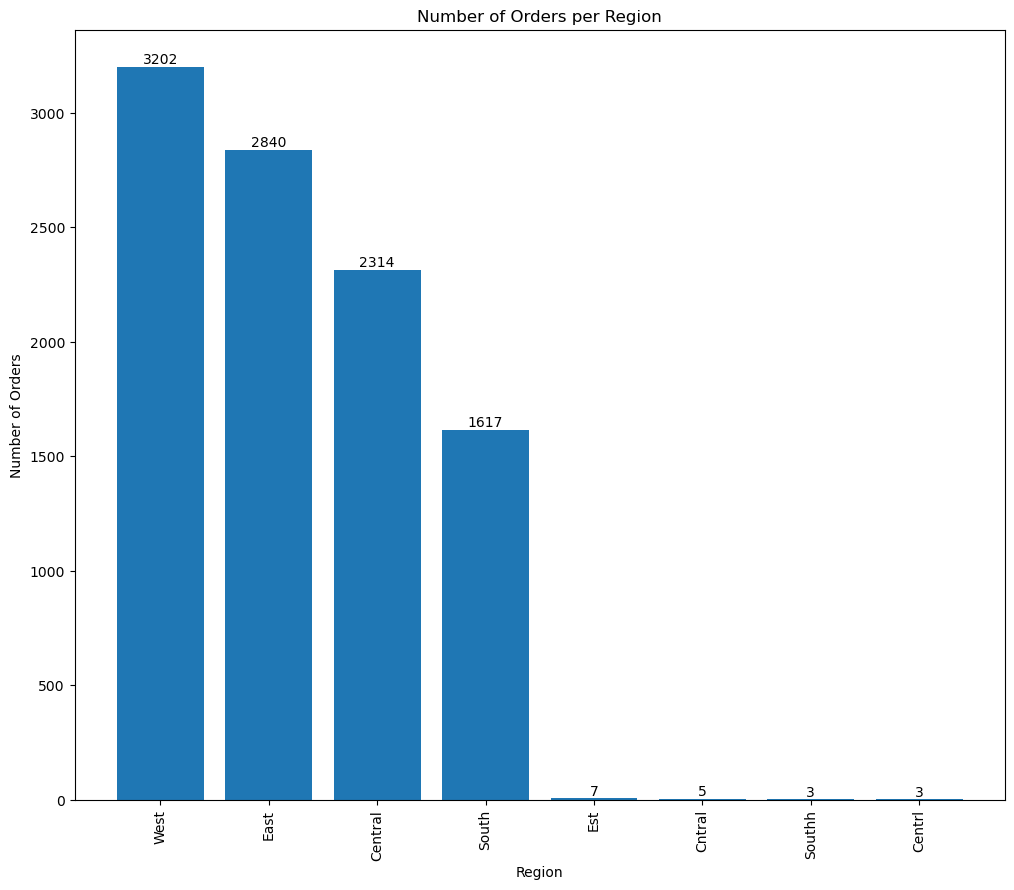

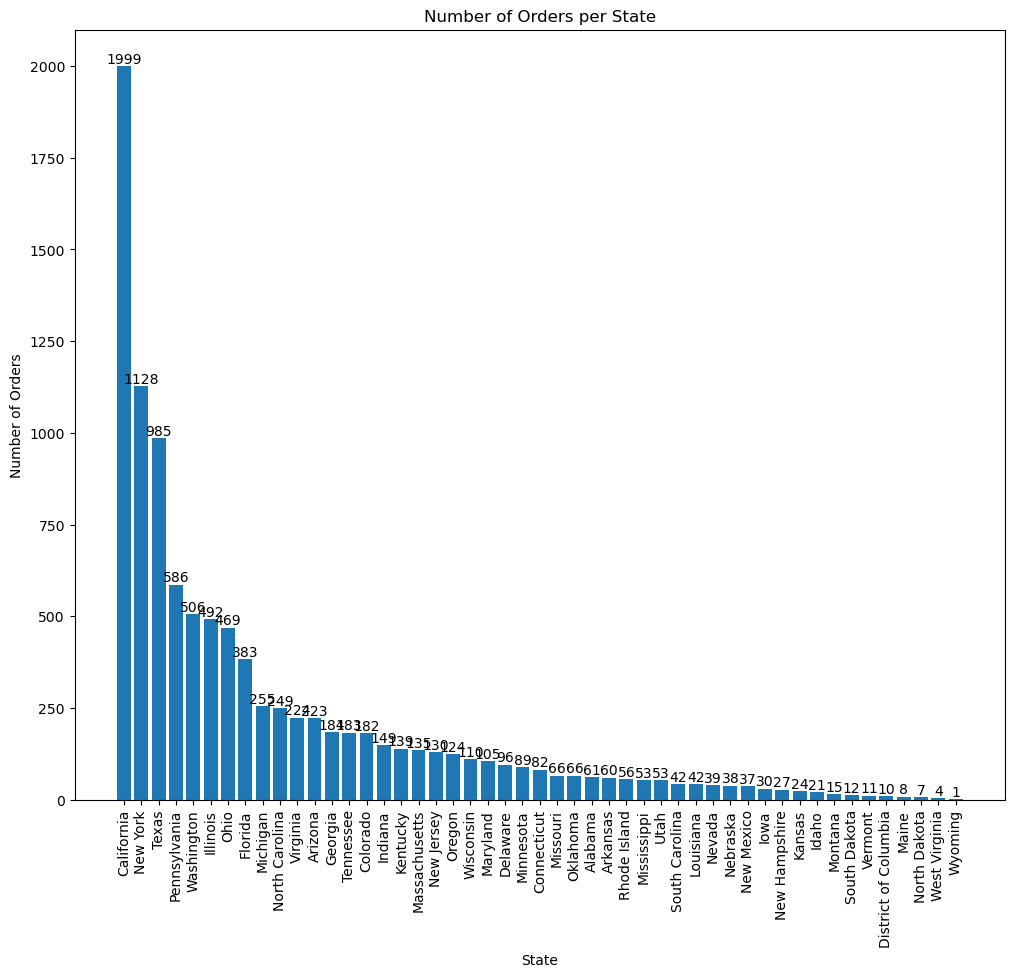

In [85]:
# Histogram for 'Ship Mode'
orders_per_segment = global_super_store_df['Ship Mode'].value_counts()
plot_histogram(orders_per_segment, 'Ship Mode', 'Number of Orders', 'Number of Orders per Ship Mode')

# Histogram for 'Segment'
orders_per_segment = global_super_store_df['Segment'].value_counts()
plot_histogram(orders_per_segment, 'Segment', 'Number of Orders', 'Number of Orders per Segment')

# Histogram for 'Category'
orders_per_category = global_super_store_df['Category'].value_counts()
plot_histogram(orders_per_category, 'Category', 'Number of Orders', 'Number of Orders per Category')

# Histogram for 'Sub-Category'
orders_per_sub_category = global_super_store_df['Sub-Category'].value_counts()
plot_histogram(orders_per_sub_category, 'Sub-Category', 'Number of Orders', 'Number of Orders per Sub-Category')

# Histogram for 'Region'
orders_per_sub_category = global_super_store_df['Region'].value_counts()
plot_histogram(orders_per_sub_category, 'Region', 'Number of Orders', 'Number of Orders per Region')

# Histogram for 'State'
orders_per_sub_category = global_super_store_df['State'].value_counts()
plot_histogram(orders_per_sub_category, 'State', 'Number of Orders', 'Number of Orders per State')

The **plot_histogram()** function can be run after the data cleansing.

## 2. Task 2

### Handling missing values in the dataset

Before performing any statistical analysis, the numerical column data has to be cleansed to be meaningful.
* Records with special characters on *Quantity* and needs to be cleansed. 
* Records with special characters on *Profit* and needs to be cleansed. 
* Applying the **text2float()** function to fix *Quantity* column. 
* City and States are missing on a few records, **get_city_from_postal_code()** and **get_state_from_postal_code()** functions will fix them via API.
* *Category/Sub-Category* needs cleansing and reorganizing.

In [86]:
def text2float(textnum, numwords={}):
    """
    text2float converts the textual representation of numbers to float.
    Parameters:
        textnum: Textual representation of a number.
        numwords: Dictionary mapping words to their numeric values.
    Returns:
        Float: The numerical value represented by the input text.
    """

    try:
        # Attempt to convert to float
        return float(textnum)
    except ValueError:
        # If conversion to float fails, continue with text to number conversion
        textnum = textnum.lower()
        
        if not numwords:
            units = [
                "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
                "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
                "sixteen", "seventeen", "eighteen", "nineteen",
            ]

            tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

            scales = ["hundred", "thousand", "million", "billion", "trillion"]

            numwords["and"] = (1, 0)
            for idx, word in enumerate(units):
                numwords[word] = (1, idx)
            for idx, word in enumerate(tens):
                numwords[word] = (1, idx * 10)
            for idx, word in enumerate(scales):
                numwords[word] = (10 ** (idx * 3 or 2), 0)

        current = result = 0
        for word in textnum.split():
            if word not in numwords:
                raise Exception("Illegal word: " + word)

            scale, increment = numwords[word]
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0

        return result + current

In [87]:
def is_internet_connected():
    """
    Check if the machine is connected to the internet by attempting to connect to Google's DNS server.
    Returns:
        bool: True if the machine is connected to the internet, False otherwise.
    """
    try:
        # Attempt to connect to Google's DNS server
        socket.create_connection(("8.8.8.8", 53), timeout=3)
        return True
    except OSError:
        pass
    return False

In [88]:
def get_city_from_postal_code(postal_code):
    """
    get_city_from_postal_code retrieves the city name from postal code using zippopotam API.
    Parameters:
        postal_code: Postal code for the city.
    Returns:
        str or None: City name corresponding to the given postal code, or None if postal_code is empty or invalid.
    """
    if not is_internet_connected():
        return None

    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        city = data['places'][0]['place name']
        return city
    else:
        return None

In [89]:
def get_state_from_postal_code(postal_code):
    """
    get_state_from_postal_code retrieves the state name from postal code using zippopotam API.
    Parameters:
        postal_code: Postal code for the state.
    Returns:
        str or None: State name corresponding to the given postal code, or None if postal_code is empty or invalid.
    """

    if not is_internet_connected():
        return None

    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        state = data['places'][0]['state']
        return state
    else:
        return None

In [90]:
# Row ID is not needed for the analysis, hence dropping the column
if 'Row ID' in global_super_store_df.columns:
    global_super_store_df.drop('Row ID', axis=1, inplace=True)

In [91]:
# Removing "?" from Quantity column
global_super_store_df['Quantity'] = global_super_store_df['Quantity'].str.replace('?', '')

# Removing """ from Profit column
global_super_store_df['Profit'] = global_super_store_df['Profit'].str.replace('"', '')

# Assuming zero values for NaN on Profits
global_super_store_df['Profit'] = global_super_store_df['Profit'].fillna(0)

# Removing """ from Postal Code column
global_super_store_df['Postal Code'] = global_super_store_df['Postal Code'].str.replace('"', '')

# Make all records as Country = United States
global_super_store_df['Country'] = 'United States'

# Correcting spelling mistakes on Category column
global_super_store_df['Category'] = global_super_store_df['Category'].replace('Frnture', 'Furniture')

# Filling values on empty Category/Sub-Category records
global_super_store_df['Category'] = global_super_store_df['Category'].fillna('NO_CATEGORY')
global_super_store_df['Sub-Category'] = global_super_store_df['Sub-Category'].fillna('NO_SUB_CATEGORY')

# Datafix on Category based on subcategories
# Apply the condition element-wise
condition = (global_super_store_df['Category'] == 'NO_CATEGORY') & \
            (global_super_store_df['Sub-Category'].isin(['Binders', 'Storage']))

# Update 'Category' where the condition is True
global_super_store_df.loc[condition, 'Category'] = 'Office Supplies'

In [92]:
# Cleanse the Regions
central_regions_to_replace = ['Centrl', 'Cntral']
east_regions_to_replace = ['Est']
south_regions_to_replace = ['Southh']

global_super_store_df['Region'] = global_super_store_df['Region'].replace(central_regions_to_replace, 'Central')
global_super_store_df['Region'] = global_super_store_df['Region'].replace(east_regions_to_replace, 'East')
global_super_store_df['Region'] = global_super_store_df['Region'].replace(south_regions_to_replace, 'South')

In [93]:
# Filter the empty state rows
state_filtered_na = global_super_store_df.loc[pd.isna(global_super_store_df['State'])]
state_filtered_na

# Apply the function to fill the missing value via API
global_super_store_df.loc[pd.isna(global_super_store_df['State']), 'State'] = state_filtered_na['Postal Code'].apply(get_state_from_postal_code)

In [94]:
# Filter the empty city rows
city_filtered_na = global_super_store_df.loc[pd.isna(global_super_store_df['City'])]
city_filtered_na

# Apply the function to fill the missing value via API
global_super_store_df.loc[pd.isna(global_super_store_df['City']), 'City'] = city_filtered_na['Postal Code'].apply(get_city_from_postal_code)

In [95]:
# Applying text2float function
global_super_store_df['Quantity'] = global_super_store_df['Quantity'].apply(text2float)
global_super_store_df['Profit'] = global_super_store_df['Profit'].apply(text2float)

Problems with fixing the Order Date and Ship Dates:

1. We cannot derive meaningful statistics on the Order/Ship Dates together.
2. A few records are in dd-mm-yyyy and a few of them are in mm-dd-yyyy.
3. In many records, the Order Date is in dd-mm-yyyy and Ship Date is in mm-dd-yyyy and vice versa.
4. The best we can do it see an year-on-year time series analysis.

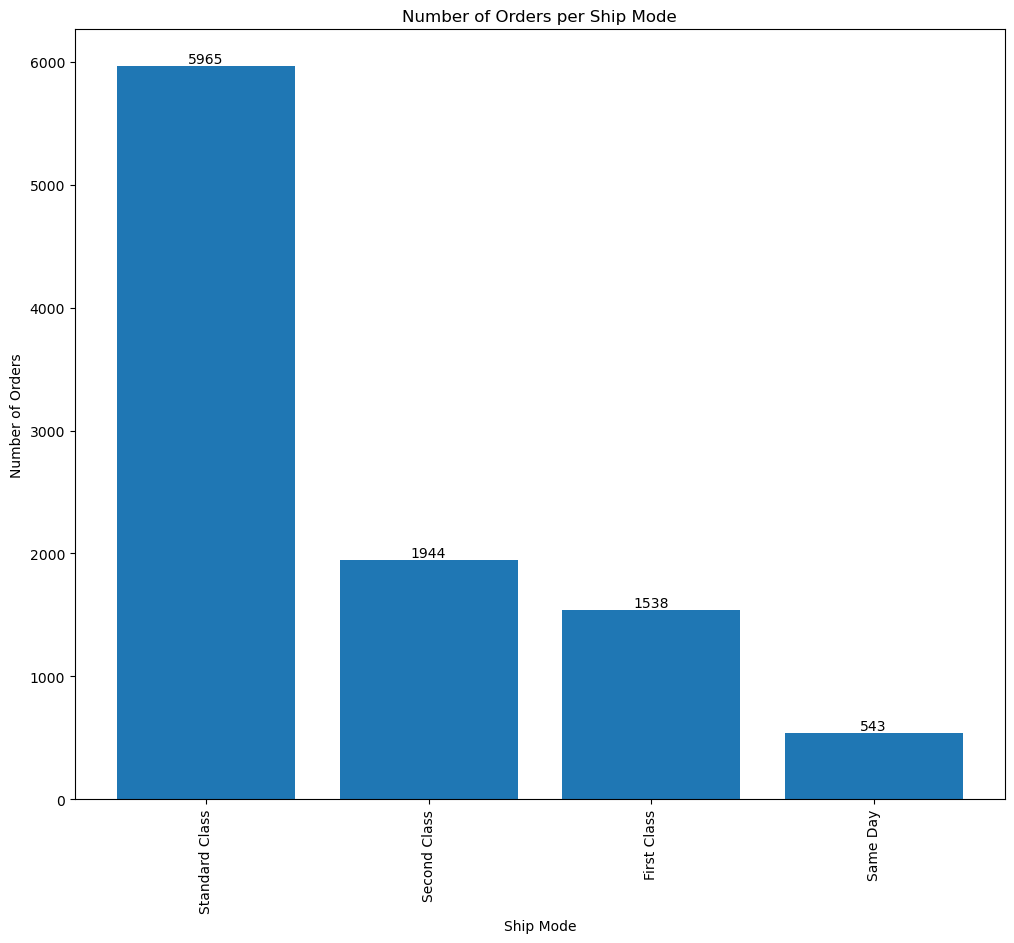

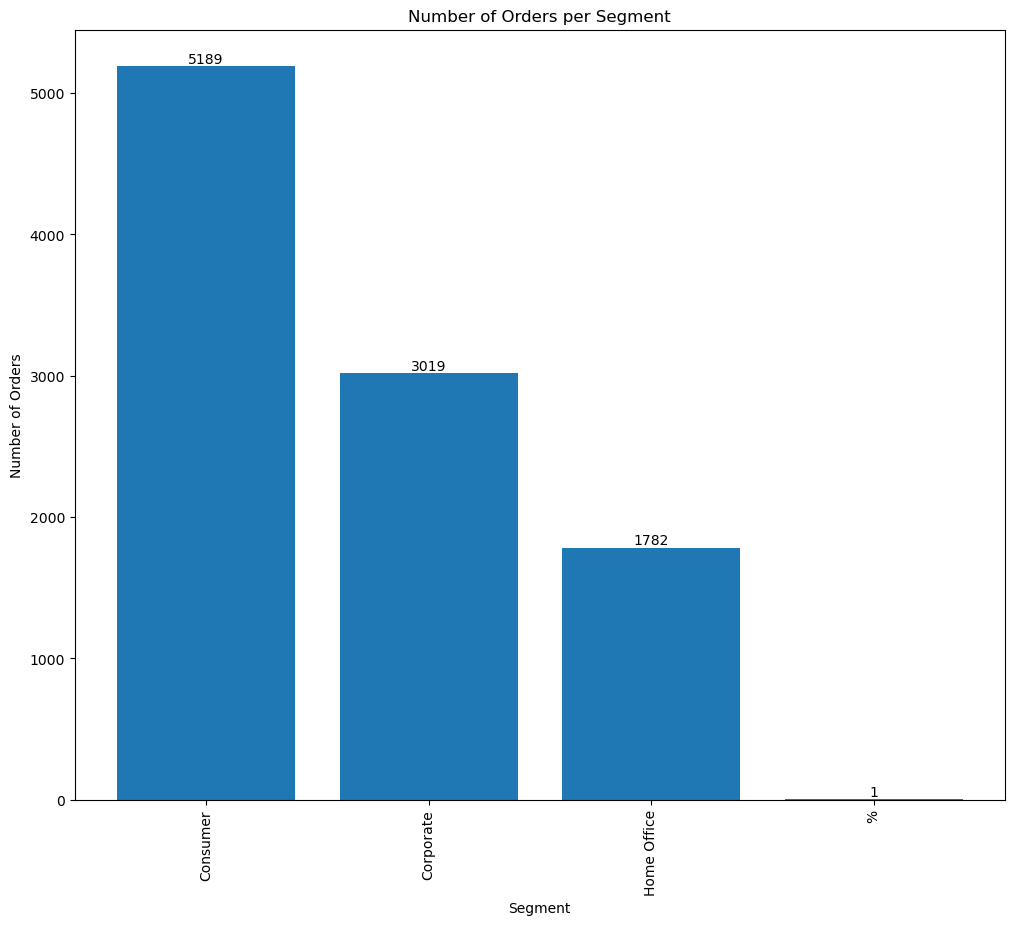

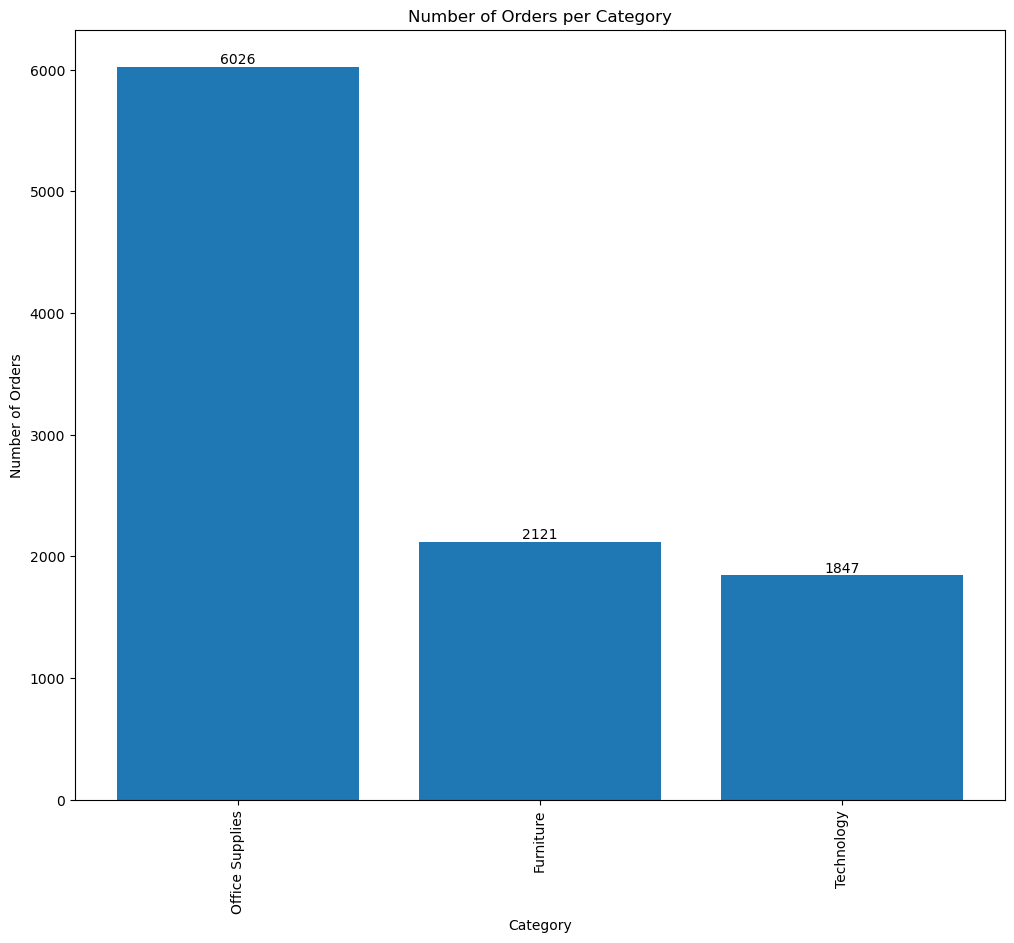

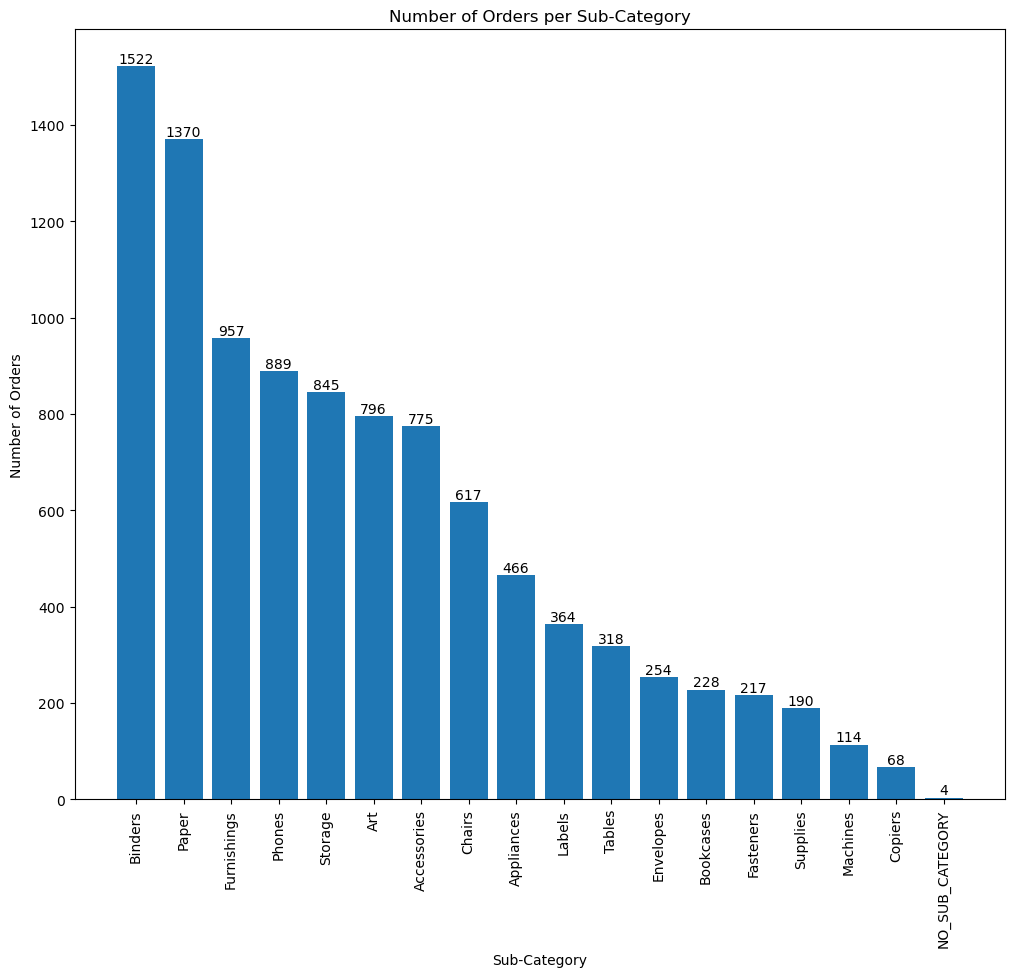

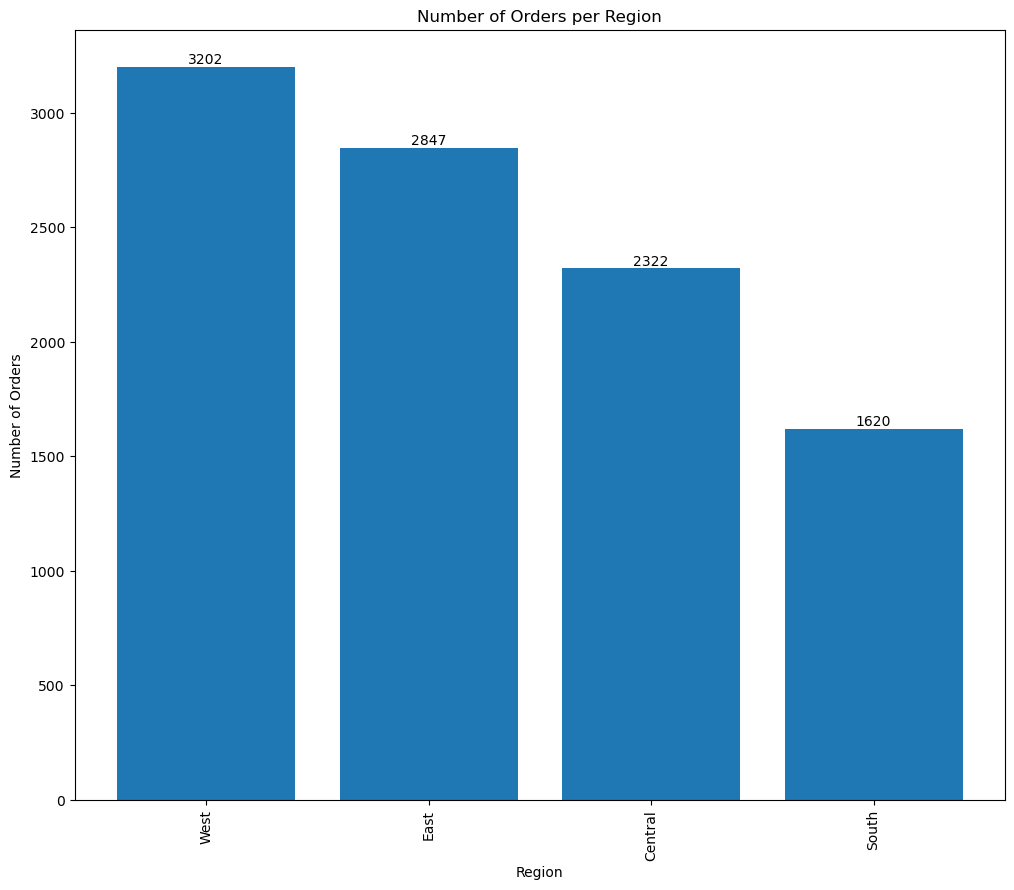

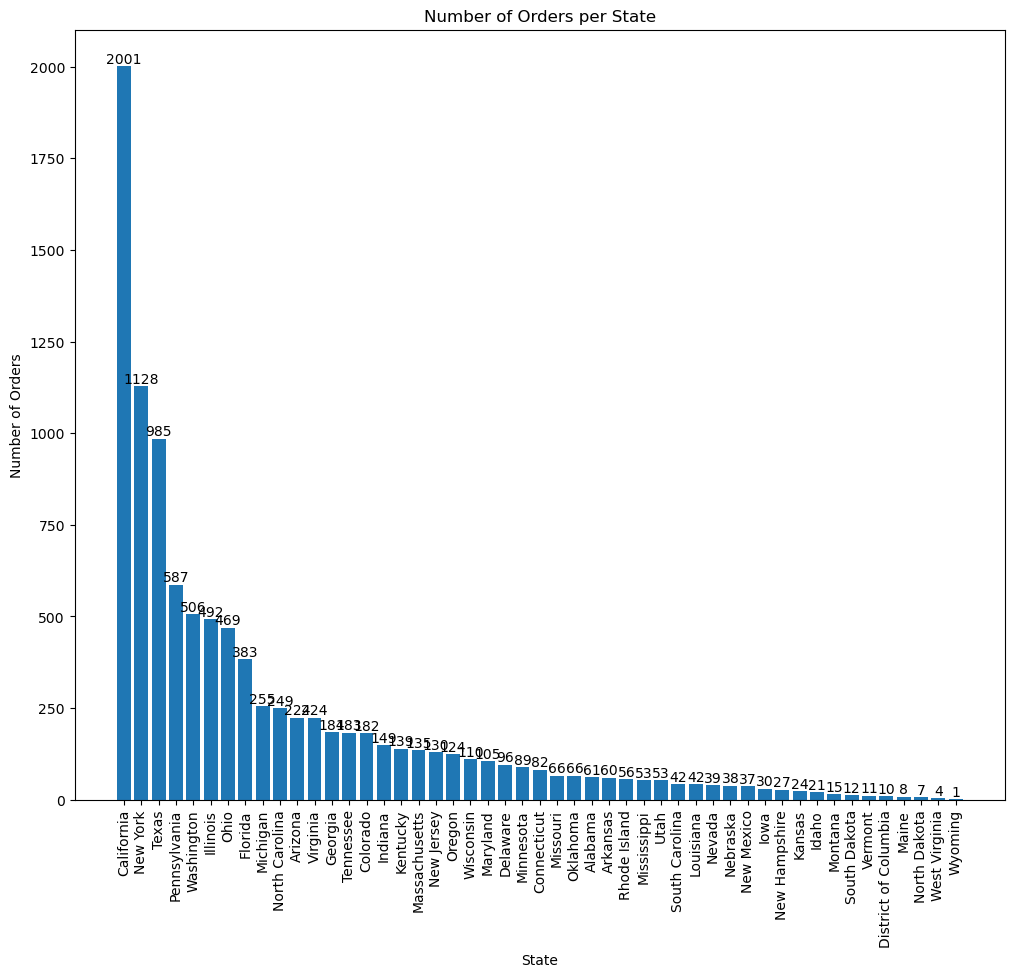

In [96]:
# Histogram for 'Ship Mode'
orders_per_segment = global_super_store_df['Ship Mode'].value_counts()
plot_histogram(orders_per_segment, 'Ship Mode', 'Number of Orders', 'Number of Orders per Ship Mode')

# Histogram for 'Segment'
orders_per_segment = global_super_store_df['Segment'].value_counts()
plot_histogram(orders_per_segment, 'Segment', 'Number of Orders', 'Number of Orders per Segment')

# Histogram for 'Category'
orders_per_category = global_super_store_df['Category'].value_counts()
plot_histogram(orders_per_category, 'Category', 'Number of Orders', 'Number of Orders per Category')

# Histogram for 'Sub-Category'
orders_per_sub_category = global_super_store_df['Sub-Category'].value_counts()
plot_histogram(orders_per_sub_category, 'Sub-Category', 'Number of Orders', 'Number of Orders per Sub-Category')

# Histogram for 'Region'
orders_per_sub_category = global_super_store_df['Region'].value_counts()
plot_histogram(orders_per_sub_category, 'Region', 'Number of Orders', 'Number of Orders per Region')

# Histogram for 'State'
orders_per_sub_category = global_super_store_df['State'].value_counts()
plot_histogram(orders_per_sub_category, 'State', 'Number of Orders', 'Number of Orders per State')

### Descriptive statistics

In [97]:
global_super_store_df.describe()

,Sales,Quantity,Discount,Profit
count,9993.000000,9989.000000,9991.000000,9994.000000
mean,229.863780,3.789368,0.156180,29.048651
std,623.276019,2.225495,0.206399,233.095599
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.480000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


In [98]:
# Columns with missing data
print(f"Sum of null records:\n{global_super_store_df.isnull().sum()}")

Sum of null records:
Order ID         1
Order Date       2
Ship Date        3
Ship Mode        4
Customer ID      0
Customer Name    3
Segment          3
Country          0
City             0
State            0
Postal Code      3
Region           3
Product ID       2
Category         0
Sub-Category     0
Product Name     3
Sales            1
Quantity         5
Discount         3
Profit           0
dtype: int64


### Grouping of data

#### Grouping Sales/Profits based on Categories

In [99]:
def print_unique_values_on_tabulate(df, column_name):
    """
    print_unique_values_on_tabulate, prints unique values from a specified column of a DataFrame in a table format.

    Parameters:
    - df (DataFrame): The DataFrame from which unique values will be extracted.
    - column_name (str): The name of the column from which unique values will be extracted.

    Returns:
    - None
    """
    # Get unique values from the specified column
    unique_values = df[column_name].unique()
    
    # Flatten unique values array
    flat_unique_values_array = unique_values.flatten()
    
    # Convert flattened array to list of lists
    data = [[item] for item in flat_unique_values_array]
    
    # Set Header
    header = [f'Unique {column_name.capitalize()}']
    
    # Print the table using tabulate
    print(tabulate(data, headers=header, tablefmt="pretty", stralign ="left"))

In [100]:
print_unique_values_on_tabulate(global_super_store_df, 'Category')

+-----------------+
| Unique Category |
+-----------------+
| Technology      |
| Office Supplies |
| Furniture       |
+-----------------+


In [101]:
def print_sales_profit_by_feature(df, feature_column, category_column):
    """
    print_sales_profit_by_feature, prints total sales/[rpfit] by category in a tabular format.

    Parameters:
    - df (DataFrame): The DataFrame containing the sales data.
    - sales_column (str): The name of the column containing sales data.
    - sales_category_column (str): The name of the column to group by.

    Returns:
    - None
    """
    # Group total sales by category
    sales_category = df.groupby(category_column)[feature_column].sum().round(4).reset_index().sort_values(by=feature_column, ascending=False)
    
    # Convert the grouped DataFrame to a list of lists
    sales_category_list = sales_category.values.tolist()

    # Print the table using tabulate
    print(tabulate(sales_category_list, headers=[category_column, 'Total Sales'], tablefmt="pretty", stralign ="left"))

In [102]:
# group total sales by category from the highest sale.
print_sales_profit_by_feature(global_super_store_df, 'Sales', 'Category')

+-----------------+-------------+
| Category        | Total Sales |
+-----------------+-------------+
| Technology      | 836154.033  |
| Furniture       | 741827.6853 |
| Office Supplies | 719047.032  |
+-----------------+-------------+


In [103]:
# group total sales by category from the highest sale.
print_sales_profit_by_feature(global_super_store_df, 'Profit', 'Category')

+-----------------+-------------+
| Category        | Total Sales |
+-----------------+-------------+
| Technology      | 145482.6639 |
| Office Supplies | 123883.7839 |
| Furniture       | 20945.7713  |
+-----------------+-------------+


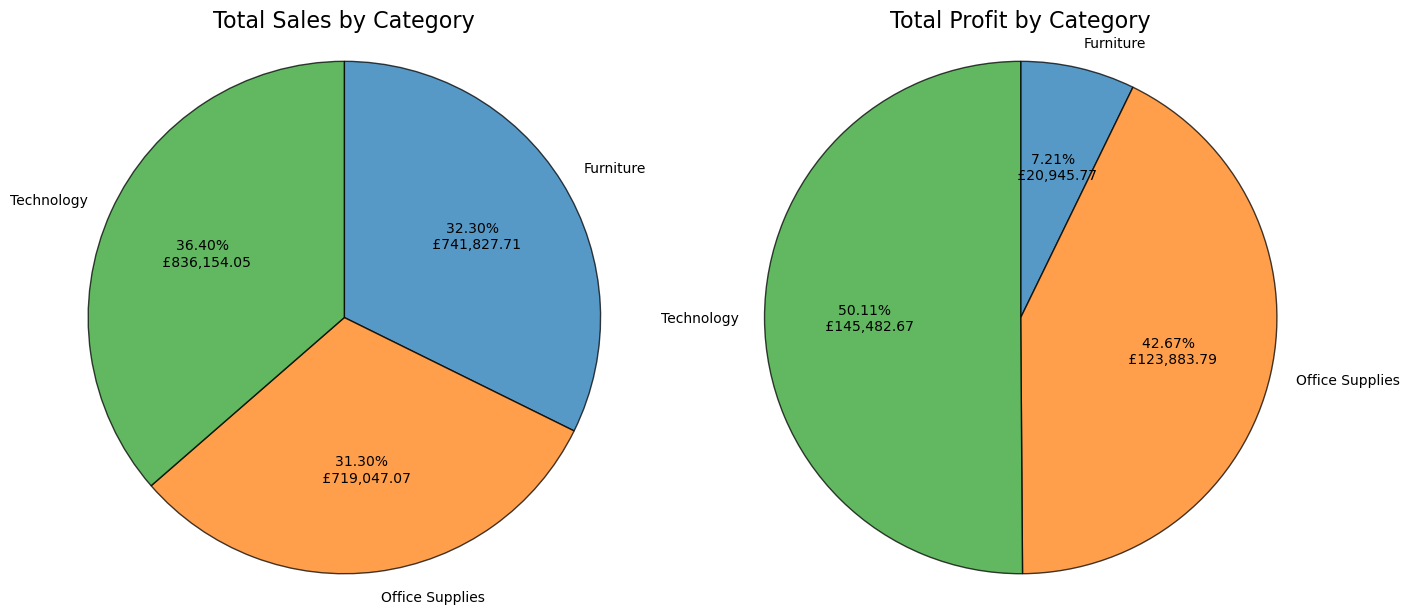

In [166]:
# group total sales by category, only considering positive sales
positive_sales_category = global_super_store_df.groupby('Category').filter(lambda x: x['Sales'].sum() > 0).groupby('Category')['Sales'].sum()

# group total profit by category, only considering positive profits
positive_profit_category = global_super_store_df.groupby('Category').filter(lambda x: x['Profit'].sum() > 0).groupby('Category')['Profit'].sum()

# figure size
plt.figure(figsize=(16,12));

# left total sales pie chart
plt.subplot(1,2,1); # 1 row, 2 columns, the 1st plot.
plt.pie(positive_sales_category.values, labels=positive_sales_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:,.2f}% \n ${p * np.sum(positive_sales_category.values) / 100 :,.2f}', 
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Sales by Category',  fontdict={'fontsize':16});

# right total profits pie chart
plt.subplot(1,2,2); # 1 row, 2 columns, the 2nd plot
plt.pie(positive_profit_category.values, labels=positive_profit_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:,.2f}% \n ${p * np.sum(positive_profit_category.values) / 100 :,.2f}',
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Profit by Category', fontdict={'fontsize':16});

 > _Total Sales on Categories_

1. Technology at 36.4% 
2. Furniture at 32.3%
3. Office Supplies at 31.3%

Sales depict a near-perfect symmmetery on categories, with **Technology** winning with a slight edge.

 > _Total Profits on Categories_

1. Technology at 50.1%
2. Office Supplies at 42.7%
3. Furniture at 7.2%

Profits are largely taken by **Technology** category with *Office Supplies* being the lowest.

#### Grouping Sales/Profits based on Sub-Categories

In [105]:
print_unique_values_on_tabulate(global_super_store_df, 'Sub-Category')

+---------------------+
| Unique Sub-category |
+---------------------+
| Machines            |
| Binders             |
| Tables              |
| Bookcases           |
| NO_SUB_CATEGORY     |
| Appliances          |
| Supplies            |
| Chairs              |
| Furnishings         |
| Phones              |
| Storage             |
| Accessories         |
| Fasteners           |
| Art                 |
| Envelopes           |
| Labels              |
| Paper               |
| Copiers             |
+---------------------+


In [106]:
# group total sales by sub-category from the highest sale.
print_sales_profit_by_feature(global_super_store_df, 'Sales', 'Sub-Category')

+-----------------+-------------+
| Sub-Category    | Total Sales |
+-----------------+-------------+
| Phones          | 330007.054  |
| Chairs          | 328449.103  |
| Storage         | 223570.872  |
| Tables          | 206191.952  |
| Binders         | 202515.743  |
| Machines        | 189058.64   |
| Accessories     | 167380.318  |
| Copiers         | 149528.03   |
| Bookcases       | 114879.9963 |
| Appliances      | 107532.161  |
| Furnishings     | 91705.164   |
| Paper           | 78479.206   |
| Supplies        | 46673.538   |
| Art             | 27118.792   |
| Envelopes       | 16476.402   |
| Labels          | 12486.312   |
| Fasteners       | 3024.28     |
| NO_SUB_CATEGORY | 1951.187    |
+-----------------+-------------+


In [107]:
# group total profit by sub-category from the highest profit.
print_sales_profit_by_feature(global_super_store_df, 'Profit', 'Sub-Category')

+-----------------+-------------+
| Sub-Category    | Total Sales |
+-----------------+-------------+
| Copiers         | 55617.8249  |
| Phones          | 44543.4464  |
| Accessories     | 41936.6357  |
| Paper           | 34053.5693  |
| Binders         | 32959.8093  |
| Chairs          | 26653.5428  |
| Storage         | 21390.8554  |
| Appliances      | 18190.9638  |
| Furnishings     | 13143.4364  |
| Envelopes       | 6964.1767   |
| Art             | 6527.787    |
| Labels          | 5546.254    |
| Machines        | 3636.7443   |
| Fasteners       | 949.5182    |
| Supplies        | -1154.3415  |
| NO_SUB_CATEGORY | -2097.5307  |
| Bookcases       | -2988.0392  |
| Tables          | -15562.4337 |
+-----------------+-------------+


In [108]:
#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_cat_subcat = global_super_store_df.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Profit']].sum()
sales_per_cat_subcat['Profit Margin %'] = (sales_per_cat_subcat['Profit'] / sales_per_cat_subcat['Sales']) * 100

#Sorting the dataframe based on profit margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Profit Margin %'], ascending=False)
sales_per_cat_subcat

,Category,Sub-Category,Sales,Profit,Profit Margin %
10,Office Supplies,Labels,12486.3120,5546.2540,44.418672
12,Office Supplies,Paper,78479.2060,34053.5693,43.391837
8,Office Supplies,Envelopes,16476.4020,6964.1767,42.267582
16,Technology,Copiers,149528.0300,55617.8249,37.195585
9,Office Supplies,Fasteners,3024.2800,949.5182,31.396504
15,Technology,Accessories,167380.3180,41936.6357,25.054700
6,Office Supplies,Art,27118.7920,6527.7870,24.071083
5,Office Supplies,Appliances,107532.1610,18190.9638,16.916766
7,Office Supplies,Binders,202515.7430,32959.8093,16.275184
2,Furniture,Furnishings,91705.1640,13143.4364,14.332275


#### Grouping Sales/Profits based on States

In [109]:
# group total sales by states from the highest sale.
sales_by_states = global_super_store_df.groupby(['State'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_states['Sales %'] = (sales_by_states['Sales'] / global_super_store_df['Sales'].sum()) * 100
print(sales_by_states.describe())
sales_by_states

               Sales    Sales %
count      49.000000  49.000000
mean    46878.137761   2.040816
std     80774.905475   3.516495
min       919.910000   0.040048
25%      7464.930000   0.324982
50%     22205.150000   0.966690
75%     49095.840000   2.137363
max    457687.631500  19.925203


,State,Sales,Sales %
3,California,457687.6315,19.925203
30,New York,310876.2710,13.533843
41,Texas,170188.0458,7.409052
45,Washington,138641.2700,6.035678
36,Pennsylvania,116511.9140,5.072288
8,Florida,89473.7080,3.895193
11,Illinois,80166.1010,3.489991
33,Ohio,78086.0260,3.399436
20,Michigan,76269.6140,3.320360
44,Virginia,70636.7200,3.075134


> **State which made the highest sales:** California
> 
> **State which made the lowest sales:** North Dakota

#### Grouping Sales/Profits based on Segment

In [110]:
# group total sales by segments from the highest sale.
sales_by_segment = global_super_store_df.groupby(['Segment'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_segment['Sales %'] = (sales_by_segment['Sales'] / global_super_store_df['Sales'].sum()) * 100
sales_by_segment

,Segment,Sales,Sales %
1,Consumer,1.160093e+06,50.504086
2,Corporate,7.057468e+05,30.724336
3,Home Office,4.295764e+05,18.701393
0,%,3.995400e+02,0.017394


**Consumer** Segment has 50% of Sales share, followed by **Corporate** and **Home Office**.

#### Grouping Sales/Profits based on Shipping Mode

In [111]:
# group total sales by segments from the highest sale.
sales_by_ship_mode = global_super_store_df.groupby(['Ship Mode'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_ship_mode['Sales %'] = (sales_by_ship_mode['Sales'] / global_super_store_df['Sales'].sum()) * 100
sales_by_ship_mode

,Ship Mode,Sales,Sales %
3,Standard Class,1.357094e+06,59.080412
2,Second Class,4.589246e+05,19.979055
0,First Class,3.514284e+05,15.299261
1,Same Day,1.283631e+05,5.588225


**Standard** shipping method is preferred as the sales percentage is nearly 60%, followed by **Second Class** and **First Class**. 
**Same Day** is not an economical option, so only preferred by 5% of the orders.

Cleaning the Order Date

In [112]:
global_super_store_df['Order Date'] = global_super_store_df['Order Date'].str.replace('$April', '')

In [113]:
global_super_store_df['Order Date'] = pd.to_datetime(global_super_store_df['Order Date'], format='%d/%m/%Y')
global_super_store_df['Ship Date'] = pd.to_datetime(global_super_store_df['Ship Date'], format='%d/%m/%Y')

In [114]:
global_super_store_df['Shipment Days'] = (global_super_store_df['Ship Date'] - global_super_store_df['Order Date']).dt.days
sales_by_ship_mode_days = global_super_store_df.groupby(['Ship Mode'], as_index=False)['Shipment Days'].sum().sort_values(by='Shipment Days', ascending=False)


In [115]:
def swap_month_and_date(ship_date):
    ship_date_swapped_as_str = dt.datetime.strftime(ship_date, '%Y-%d-%m %H:%M:%S')
    return pd.to_datetime(ship_date_swapped_as_str, format='%d/%m/%Y')

In [116]:
# Assumption:
# All ship modes must deliver within 30 days
# if it is more than 30 days, then it is not acceptable
acceptable_shipment_days = np.arange(0, 31)

# Get the all the records out of that filter to fix
ship_date_fix_condition = (~global_super_store_df['Shipment Days'].isin(acceptable_shipment_days)) & \
                            (~global_super_store_df['Ship Date'].isna()) & \
                            (~global_super_store_df['Order Date'].isna())

# Apply a function to swap the date and month
global_super_store_df.loc[ship_date_fix_condition, 'Ship Date'] = global_super_store_df.loc[ship_date_fix_condition, 'Ship Date'].apply(swap_month_and_date)


    # lambda x: pd.to_datetime(dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S')))


ValueError: time data "2016-12-02 00:00:00" doesn't match format "%d/%m/%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
global_super_store_df['Shipment Days'] = (global_super_store_df['Ship Date'] - global_super_store_df['Order Date']).dt.days

Problems with fixing the dates:

1. We cannot take meaningful stats on the Order/Ship Dates together.
2. A few records are in dd-mm-yyyy and a few of them are in mm-dd-yyyy.
3. Worst case in many scenarios, the Order Date is in dd-mm-yyyy and Ship Date is in mm-dd-yyyy and vice versa.
4. The best we can do it see an year-on-year time series analysis.

### Univariate analysis and visualisation

#### Profit Margin by Sub-categories

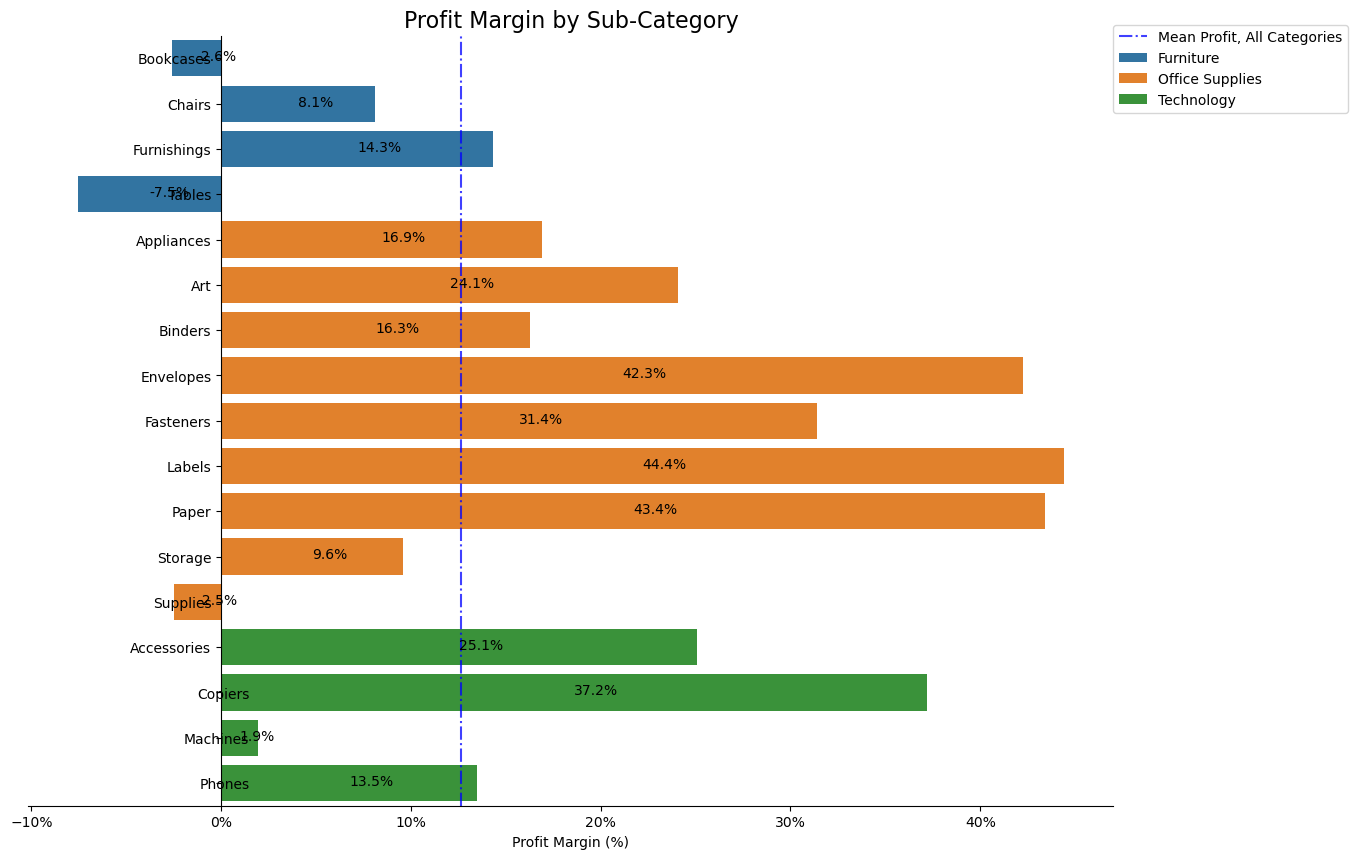

In [ ]:
#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_cat_subcat = global_super_store_df.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Profit']].sum()
sales_per_cat_subcat['Profit Margin'] = sales_per_cat_subcat['Profit'] / sales_per_cat_subcat['Sales']

#Sorting the dataframe based on profit margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Category', 'Sub-Category', 'Profit Margin'], ascending=True)

# plot a profit margins sub-category bar chart 
fig, ax = plt.subplots(figsize=(14,10))

# Unique sub categories without NO_SUB_CATEGORY
unique_sub_categories_without_custom_label = sales_per_cat_subcat[sales_per_cat_subcat['Sub-Category'] != 'NO_SUB_CATEGORY']['Sub-Category'].unique()

#Plotting the profit margin per sub-category.
sns.barplot(y=sales_per_cat_subcat['Sub-Category'], x=sales_per_cat_subcat['Profit Margin'], hue=sales_per_cat_subcat['Category'], 
                alpha=1, dodge=False, ax=ax, order=unique_sub_categories_without_custom_label)

#Cleaning out bar junk
ax.spines['left'].set_position(('data', 0.0))
ax.spines[['right','top']].set_visible(False)
ax.set(ylabel=None, xlabel='Profit Margin (%)')

def move_ylabel_tick(index: list):
    """
    Moving the provided ylabel ticks
    """
    for tick in index:
        ax.get_yticklabels()[tick].set_x(0.02)
        ax.get_yticklabels()[tick].set_horizontalalignment('right')

#Moving the y-labels on sub-categories that are making a loss in order to prevent collision of the bar and the text.
move_ylabel_tick([-1, -2, -3])

#Annotating the profit margin amount for each bar.
for p in ax.patches:
    _, y = p.get_xy()
    
    ax.annotate(f'{p.get_width()*100 :.1f}%', (p.get_width() / 2, y + 0.45))
    
#Calculating Superstore's aggregate profit margin in order to compare it to each sub-category's profit margin
mean_profit = sales_per_cat_subcat['Profit'].sum() / sales_per_cat_subcat['Sales'].sum()

#Plotting a vertical line and annotating the Superstore's aggregate profit margin.
ax.axvline(mean_profit, color='blue', label='Mean Profit, All Categories', alpha=0.75, ls='-.')

#Setting the title and legend.
ax.set_title('Profit Margin by Sub-Category', fontdict={'fontsize':16})
ax.legend(loc=(1, 0.9))

#Formatting the x-axis as %
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#### Geo Analysis

In [ ]:
def geo_analysis_by_state(df, feature_column):
    """
    geo_analysis_by_state, plots the feature percentages on a US map grouped by States

    Args:
    - df (DataFrame): DataFrame containing the feature data.
    - feature_column (str): Name of the numerical feature column.

    Returns:
    - None
    """
    
    base_folder_path = os.getcwd()
    shp_path = '/data/usa-states-census-2014.shp'

    us_states = gpd.read_file(f'{base_folder_path}{shp_path}')
    us_states = us_states.to_crs("EPSG:3395")

    # Group feature data based on States
    feature_per_states = df.groupby(['State'], as_index=False)[[feature_column]].sum()

    # Create a new column to see the Feature %
    feature_percent_column_name = feature_column + ' %'
    feature_per_states[feature_percent_column_name] = (feature_per_states[feature_column] / df[feature_column].sum()) * 100

    # Merge sales data with the US map based on state codes or names
    merged_data = us_states.merge(feature_per_states, how='left', left_on='NAME', right_on='State')

    # Filter out duplicate entries
    merged_data = merged_data.drop_duplicates(subset=['NAME'])

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(30, 10))
    us_states.plot(ax=ax, color='lightgrey', edgecolor='black')
    merged_data.plot(column=feature_percent_column_name, cmap='Spectral_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, aspect='equal')

    # Annotate state names and sales percentages
    texts = []
    for idx, row in merged_data.iterrows():
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        name = row['NAME']
        feature_percent = row[feature_percent_column_name]
        text = ax.text(x, y, name, fontsize=9, ha='center', va='center', color='black')
        texts.append(text)
        text = ax.text(x, y-0.5, f"{feature_percent:.2f}%", fontsize=9, ha='center', va='center', color='black')  # Adjust y position
        texts.append(text)

    # Adjust text labels to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))

    ax.axis('off')
    ax.set_title(f'{feature_column} percent by US State', loc='center', fontsize=20, y=1.0)
    plt.show()

##### Sales % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Sales')

##### Profit % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Profit')

##### Discount % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Discount')

* Sales conclusion:
    * **California** has the most percentage of Sales with ~20%.
    * The Central and South regions of the country collectively could not match the sales numbers of California.

* Profits conclusion:
    * **California** and **New York** are nearly tied with ~25% of the Profits. **Texas** despite of making ~7% of Sales, has grossed an ~8% of losses.

* Discounts conclusion:
    * **Texas** has received nearly ~24% discounts in Total. This coincides with the ~8% of the losses that the company made.

#### Time series analysis

In [142]:
global_super_store_df['Order Year'] = pd.DatetimeIndex(global_super_store_df['Order Date']).year
global_super_store_df['Ship Year'] = pd.DatetimeIndex(global_super_store_df['Ship Date']).year

global_super_store_df['Order Year'] = global_super_store_df['Order Year'].fillna(0)
global_super_store_df['Ship Year'] = global_super_store_df['Ship Year'].fillna(0)

global_super_store_df['Order Year'] = global_super_store_df['Order Year'].astype(int)
global_super_store_df['Ship Year'] = global_super_store_df['Ship Year'].astype(int)

Order Year
2014    483375.3321
2015    469406.1890
2016    609205.5980
2017    733215.2552
Name: Sales, dtype: float64


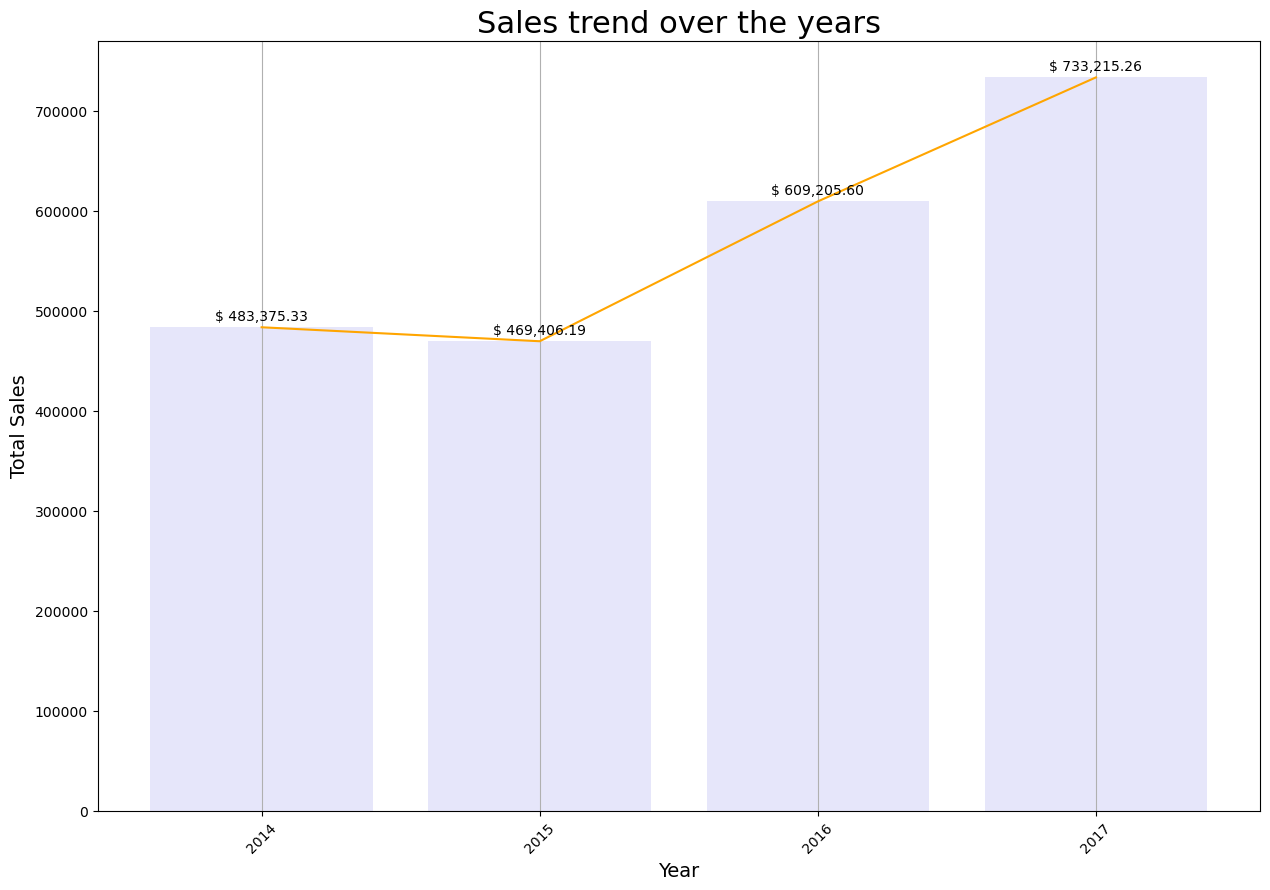

In [170]:
# sales trend
sales_trend = global_super_store_df[global_super_store_df['Order Year'] > 0]
sales_trend = sales_trend.groupby('Order Year')['Sales'].sum()

print(sales_trend)

fig, ax = plt.subplots(figsize=(15,10))

# Plot the bar plot
bars = ax.bar(x=sales_trend.index, height=sales_trend.values, color='lavender')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.annotate('$ {:,.2f}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Plot the line plot
ax.plot(sales_trend.index, sales_trend.values, color='orange')

# Turn off scientific notation for y-axis
ax.yaxis.get_major_formatter().set_scientific(False)

# Set title and labels
plt.title('Sales trend over the years', fontsize=22)
plt.ylabel('Total Sales', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Convert 'Order Year' column to a list of integers
years = [2014, 2015, 2016, 2017]

# Set x-ticks to only include specific years
plt.xticks(years, rotation=45)

# Add gridlines
plt.grid(axis='x')

# Show the plot
plt.show()

### Correlation 

In [ ]:
#Select Numerical Features
numerical_features = ['Sales', 'Quantity', 'Discount', 'Profit']
global_super_store_numerial_data = global_super_store_df[numerical_features]

correlation_matrix = global_super_store_numerial_data.corr()
correlation_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix as heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


#### Outlier Treatment

##### Interquartile Range (IQR) Method

In [ ]:
numerical_features = ['Sales', 'Quantity', 'Discount', 'Profit']

for numerical_feature in numerical_features:
    q1 = global_super_store_df[numerical_feature].quantile(0.25)
    q3 = global_super_store_df[numerical_feature].quantile(0.75)
    
    iqr = q3 - q1
    
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5* iqr

    outliers_df = global_super_store_df[(global_super_store_df[numerical_feature] < lower_limit)|(global_super_store_df[numerical_feature] > upper_limit)]
    sns.boxplot(outliers_df)
    print(f"Outlier numerical feature: {numerical_feature}, Outlier Count: {outliers_df[numerical_feature].count()}")